Elisabeth Vehling
INF 352
Lab 6

# Deep CNNs for Image Colorization 

 **1(a) Download dataset**

In [405]:
import tensorflow as tf
import tensorflow.keras as tfk
import matplotlib.pyplot as plt
import numpy as np

In [406]:
(xtrain, ytrain), (xtest, ytest) = tfk.datasets.cifar10.load_data()

In [408]:
data = np.concatenate([xtrain, xtest])
ys = np.concatenate([ytrain, ytest])

**1(b) Extract the birds class from train and test set**

In [409]:
x = data[(ys==2).reshape(-1)] #6000 members

**1(c) Choose at least 10% of the pixels randomly (between P=61440 and P=6144000 pixels**

In [412]:
from numpy import random
#Select random 10% subsample from all x data
r = x[np.random.choice(x.shape[0], 6000, replace=False), :]

In [414]:
#r = 6144000 pixels
pixels = []
#Add the pixel vectors
for i in range(0,6000):
    for j in range(0,32):
        for k in range(0,32):
            pixels.append(r[i,j,k])
len(pixels)

6144000

**1(d) Run K-means clustering on the P vectors using k=4. Centers of clusters will be main colors.**

In [415]:
import sklearn as sk
from sklearn.cluster import KMeans

In [416]:
km = KMeans(n_clusters=4, random_state=0).fit(pixels)

In [417]:
#Centers of clusters (aka main colors)
[c1,c2,c3,c4] = km.cluster_centers_

c1 = c1.astype('int32')
c2 = c2.astype('int32')
c3 = c3.astype('int32')
c4 = c4.astype('int32')

clusters = [c1, c2, c3, c4]
clusters

[array([107, 107,  81], dtype=int32),
 array([205, 210, 210], dtype=int32),
 array([155, 154, 133], dtype=int32),
 array([48, 49, 37], dtype=int32)]

**1(d) Convert colored images to k-color images by converting each pixel's value to the closest main color in terms of Euclidean distance**

In [418]:
from numpy import linalg

In [419]:
#Convert to one hot encoding

#New matrix to store one hot encoded colors
newX = np.zeros(shape=(6000,32,32,4),dtype='int32') 

#Iterate thru each pixel and find closest cluster
for i in range(0,6000):
    for j in range(0,32):
        for k in range(0,32):
            #Get the pixel vector from original array
            old = x[i,j,k]
            
            #To store min cluster and distance
            minC = 0
            minDist = 1000
            
            #Iterate thru each cluster and calculate the distance
            for c in range(0,4):
                dist = linalg.norm(old-clusters[c])
                #Replace if it's the minimum distance so far
                if dist < minDist:
                    minDist = dist
                    minC = c
            #Assign the nearest cluster as the encoded class of the pixel
            newX[i,j,k,minC] = 1

**1(e) Obtain grayscale 32x32x1 images from the original 32x32x3 images**

In [420]:
#Convert  data to grayscale images
gray = tf.image.rgb_to_grayscale(x)
graytrain = gray[0:5000]
graytest = gray[5000:]

In [421]:
newX = newX.reshape(-1, 32*32*4)

**1(f) Set up a deep CNN with two convolution layers and two MLP layers. Use 5x5 filters and a softmax output layer. Determine # of filters, strides, and whether or not to use padding. Use a min of one max pooling layer. Use a classiciation scheme**

In [422]:
newX = newX.astype('float32')
newXtrain = newX[0:5000]
newXtest = newX[5000:]

In [424]:
#Create a tf model
model = tfk.Sequential()

#Add 2 convolutional layers
model.add(tfk.layers.Conv2D(filters = 64, kernel_size=5, strides=1,activation='relu', input_shape=(32,32,1)))
model.add(tfk.layers.Conv2D(filters = 64, kernel_size=5, strides=2,activation='relu'))
    
#Flatten before passing through MLP
model.add(tfk.layers.Flatten())

#Add 2 MLP layers
model.add(tfk.layers.Dense(512, activation='relu'))

#Second layer must have 4069 neurons (output layer)
model.add(tfk.layers.Dense(4096, activation='linear'))

#define loss
#use a loss function that supports multilabel classification
def lossF(y_actual, y_pred):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(y_actual, y_pred)
    return tf.reduce_mean(loss)


optimizer = tfk.optimizers.Adam(1e-3)

#compile model
model.compile(loss=lossF, optimizer=optimizer)

#start training the model
history = model.fit(x=graytrain, y=newXtrain, validation_split = 0.1, epochs=30, batch_size=32)

Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 11s 2ms/sample - loss: 0.5516 - val_loss: 0.4868
Epoch 2/30
4500/4500 [==============================] - 11s 2ms/sample - loss: 0.4827 - val_loss: 0.4702
Epoch 3/30
4500/4500 [==============================] - 11s 2ms/sample - loss: 0.4627 - val_loss: 0.4652
Epoch 4/30
4500/4500 [==============================] - 11s 2ms/sample - loss: 0.4438 - val_loss: 0.4505
Epoch 5/30
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.4307 - val_loss: 0.4377
Epoch 6/30
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.4169 - val_loss: 0.4389
Epoch 7/30
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.4054 - val_loss: 0.4354
Epoch 8/30
4500/4500 [==============================] - 12s 3ms/sample - loss: 0.3926 - val_loss: 0.4270
Epoch 9/30
4500/4500 [==============================] - 11s 3ms/sample - loss: 0.3767 - val_loss: 0.4259
Epoch 10

In [425]:
# # Evaluate the model on the test data using `evaluate`
results = model.evaluate(graytest, newXtest, batch_size=128)
print('test loss:', results)

1000/1000 [==============================] - 0s 490us/sample - loss: 0.5708
test loss, test acc: 0.5707771310806274


dict_keys(['loss', 'val_loss'])


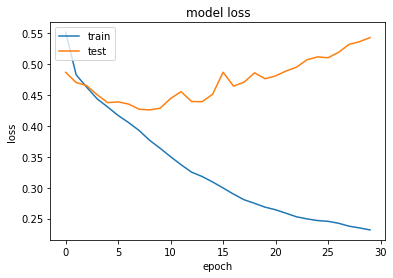

In [426]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [431]:
clusters = [c1, c2, c3, c4]
out = model.predict(x=graytrain[0:5000]).reshape(5000,32,32,4)

#Output array to store converted RGB values
finalOut = np.zeros(shape=(6000,32,32,3),dtype='int32') 

#find max
for i in range(0,5000):
    for j in range(0,32):
        for k in range(0,32):
            m = np.argmax(out[i,j,k])
            #Assign to nearest cluster
            finalOut[i,j,k] = clusters[m]

Image 1


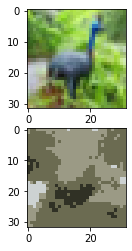

In [453]:
#compare 10 artifically colored images with original images
print("Image 1")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[0])
axarr[1].imshow(finalOut[0])

Image 2


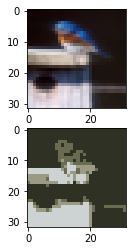

In [454]:
print("Image 2")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[1])
axarr[1].imshow(finalOut[1])

Image 3


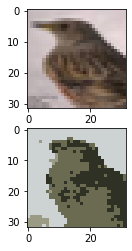

In [463]:
print("Image 3")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[2])
axarr[1].imshow(finalOut[2])

Image 4


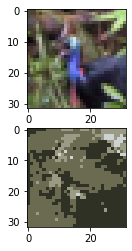

In [464]:
print("Image 4")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[3])
axarr[1].imshow(finalOut[3])

Image 5


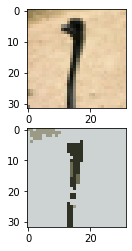

In [465]:
print("Image 5")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[4])
axarr[1].imshow(finalOut[4])

Image 6


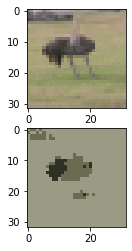

In [466]:
print("Image 6")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[5])
axarr[1].imshow(finalOut[5])

Image 7


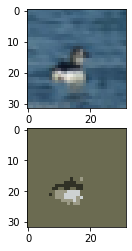

In [467]:
print("Image 7")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[6])
axarr[1].imshow(finalOut[6])

Image 8


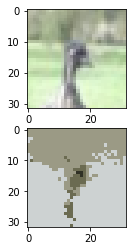

In [468]:
print("Image 8")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[7])
axarr[1].imshow(finalOut[7])

Image 9


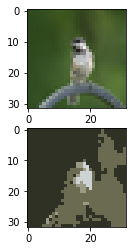

In [469]:
print("Image 9")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[8])
axarr[1].imshow(finalOut[8])

Image 10


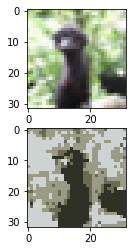

In [470]:
print("Image 10")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[9])
axarr[1].imshow(finalOut[9])

**1(g) Repeat whole exercise with k=16 (extra credit)**

In [471]:
km = KMeans(n_clusters=16, random_state=0).fit(pixels)
#Centers of clusters (aka main colors)
[c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16] = km.cluster_centers_

c1 = c1.astype('int32')
c2 = c2.astype('int32')
c3 = c3.astype('int32')
c4 = c4.astype('int32')
c5 = c4.astype('int32')
c6 = c4.astype('int32')
c7 = c4.astype('int32')
c8 = c4.astype('int32')
c9 = c4.astype('int32')
c10 = c4.astype('int32')
c11 = c4.astype('int32')
c12 = c4.astype('int32')
c13 = c4.astype('int32')
c14 = c4.astype('int32')
c15 = c4.astype('int32')
c16 = c4.astype('int32')
clusters = [c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16] 

In [499]:
#One hot encoding, this time using 16 potential classes (colors)
newX = np.zeros(shape=(6000,32,32,16),dtype='int32') 

#Same process as before, but this time find the min of each of the 16 classes
for i in range(0,6000):
    for j in range(0,32):
        for k in range(0,32):
            old = x[i,j,k]
            minC = 0
            minDist = 1000
            for c in range(0,16):
                dist = linalg.norm(old-clusters[c])
                if dist < minDist:
                    minDist = dist
                    minC = c
            #Assign to nearest cluster
            newX[i,j,k,minC] = 1

In [501]:
newX = newX.reshape(-1, 32*32*16)
newX = newX.astype('float32')
newXtrain = newX[0:5000]
newXtest = newX[5000:]

In [502]:
#Create a tf model
model = tfk.Sequential()

#Add 2 convolutional layers
model.add(tfk.layers.Conv2D(filters = 64, kernel_size=5, strides=1,activation='relu', input_shape=(32,32,1)))
model.add(tfk.layers.Conv2D(filters = 64, kernel_size=5, strides=2,activation='relu'))
    
#Flatten before passing through MLP
model.add(tfk.layers.Flatten())

#Add 2 MLP layers
model.add(tfk.layers.Dense(512, activation='relu'))

#Second layer must have 4069 neurons (output layer)
model.add(tfk.layers.Dense(16384, activation='linear'))

#define loss
#use a loss function that supports multilabel classification
def lossF(y_actual, y_pred):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(y_actual, y_pred)
    return tf.reduce_mean(loss)


optimizer = tfk.optimizers.Adam(1e-3)

#compile model
model.compile(loss=lossF, optimizer=optimizer)

#start training the model
history = model.fit(x=graytrain, y=newXtrain, validation_split = 0.1, epochs=15, batch_size=32)

Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 23s 5ms/sample - loss: 0.1376 - val_loss: 0.1071
Epoch 2/15
4500/4500 [==============================] - 22s 5ms/sample - loss: 0.1056 - val_loss: 0.1014
Epoch 3/15
4500/4500 [==============================] - 19s 4ms/sample - loss: 0.1008 - val_loss: 0.0983
Epoch 4/15
4500/4500 [==============================] - 18s 4ms/sample - loss: 0.0950 - val_loss: 0.0947
Epoch 5/15
4500/4500 [==============================] - 18s 4ms/sample - loss: 0.0913 - val_loss: 0.0955
Epoch 6/15
4500/4500 [==============================] - 20s 4ms/sample - loss: 0.0879 - val_loss: 0.0938
Epoch 7/15
4500/4500 [==============================] - 21s 5ms/sample - loss: 0.0840 - val_loss: 0.0910
Epoch 8/15
4500/4500 [==============================] - 22s 5ms/sample - loss: 0.0807 - val_loss: 0.0918
Epoch 9/15
4500/4500 [==============================] - 18s 4ms/sample - loss: 0.0764 - val_loss: 0.0934
Epoch 10

In [503]:
results = model.evaluate(graytest, newXtest, batch_size=128)
print('test loss:', results)

1000/1000 [==============================] - 1s 656us/sample - loss: 0.1139
test loss: 0.11385549986362457


dict_keys(['loss', 'val_loss'])


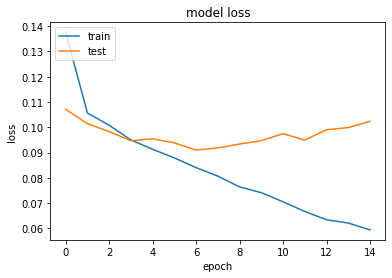

In [504]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [505]:
out = model.predict(x=graytrain[0:5000]).reshape(5000,32,32,16)

#Output array to store converted RGB values
finalOut = np.zeros(shape=(6000,32,32,3),dtype='int32') 

#find max
for i in range(0,5000):
    for j in range(0,32):
        for k in range(0,32):
            m = np.argmax(out[i,j,k])
            #Assign to nearest cluster
            finalOut[i,j,k] = clusters[m]

Image 1


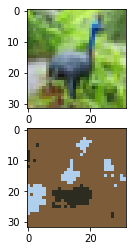

In [506]:
print("Image 1")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[0])
axarr[1].imshow(finalOut[0])

Image 2


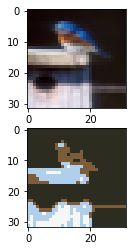

In [507]:
print("Image 2")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[1])
axarr[1].imshow(finalOut[1])

Image 3


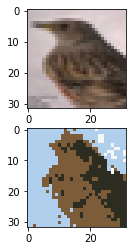

In [508]:
print("Image 3")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[2])
axarr[1].imshow(finalOut[2])

Image 4


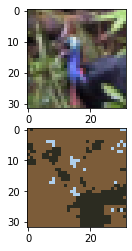

In [509]:
print("Image 4")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[3])
axarr[1].imshow(finalOut[3])

Image 5


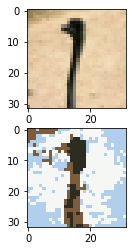

In [510]:
print("Image 5")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[4])
axarr[1].imshow(finalOut[4])

Image 6


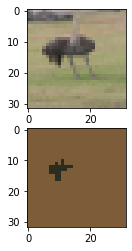

In [511]:
print("Image 6")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[5])
axarr[1].imshow(finalOut[5])

Image 7


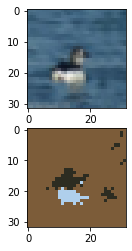

In [512]:
print("Image 7")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[6])
axarr[1].imshow(finalOut[6])

Image 8


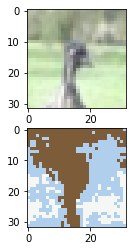

In [513]:
print("Image 8")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[7])
axarr[1].imshow(finalOut[7])

Image 9


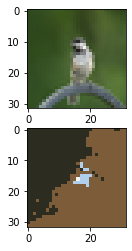

In [514]:
print("Image 9")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[8])
axarr[1].imshow(finalOut[8])

Image 10


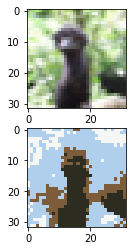

In [515]:
print("Image 10")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[9])
axarr[1].imshow(finalOut[9])

**1(g) Repeat whole exercise with k=24**

In [491]:
km = KMeans(n_clusters=24, random_state=0).fit(pixels)
#Centers of clusters (aka main colors)
[c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24] = km.cluster_centers_

c1 = c1.astype('int32')
c2 = c2.astype('int32')
c3 = c3.astype('int32')
c4 = c4.astype('int32')
c5 = c4.astype('int32')
c6 = c4.astype('int32')
c7 = c4.astype('int32')
c8 = c4.astype('int32')
c9 = c4.astype('int32')
c10 = c4.astype('int32')
c11 = c4.astype('int32')
c12 = c4.astype('int32')
c13 = c4.astype('int32')
c14 = c4.astype('int32')
c15 = c4.astype('int32')
c16 = c4.astype('int32')
c17 = c4.astype('int32')
c18 = c4.astype('int32')
c19 = c4.astype('int32')
c20 = c4.astype('int32')
c21 = c4.astype('int32')
c22 = c4.astype('int32')
c23 = c4.astype('int32')
c24 = c4.astype('int32')

clusters = [c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24]

In [516]:
#Assign to nearest class using one hot encoding
newX = np.zeros(shape=(6000,32,32,24),dtype='int32') 

#Repeat with 24 color
for i in range(0,6000):
    for j in range(0,32):
        for k in range(0,32):
            old = x[i,j,k]
            minC = 0
            minDist = 1000
            for c in range(0,24):
                dist = linalg.norm(old-clusters[c])
                if dist < minDist:
                    minDist = dist
                    minC = c
            #Assign to nearest cluster
            newX[i,j,k,minC] = 1

In [517]:
newX = newX.reshape(-1, 32*32*24)
newX = newX.astype('float32')
newXtrain = newX[0:5000]
newXtest = newX[5000:]

In [518]:
#Create a tf model
model = tfk.Sequential()

#Add 2 convolutional layers
model.add(tfk.layers.Conv2D(filters = 64, kernel_size=5, strides=1,activation='relu', input_shape=(32,32,1)))
model.add(tfk.layers.Conv2D(filters = 64, kernel_size=5, strides=2,activation='relu'))
    
#Flatten before passing through MLP
model.add(tfk.layers.Flatten())

#Add 2 MLP layers
model.add(tfk.layers.Dense(512, activation='relu'))

#Second layer must have 4069 neurons (output layer)
model.add(tfk.layers.Dense(24576, activation='linear'))

#define loss
#use a loss function that supports multilabel classification
def lossF(y_actual, y_pred):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(y_actual, y_pred)
    return tf.reduce_mean(loss)


optimizer = tfk.optimizers.Adam(1e-3)

#compile model
model.compile(loss=lossF, optimizer=optimizer)

#start training the model
history = model.fit(x=graytrain, y=newXtrain, validation_split = 0.1, epochs=15, batch_size=32)

Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 23s 5ms/sample - loss: 0.0998 - val_loss: 0.0738
Epoch 2/15
4500/4500 [==============================] - 22s 5ms/sample - loss: 0.0728 - val_loss: 0.0684
Epoch 3/15
4500/4500 [==============================] - 23s 5ms/sample - loss: 0.0696 - val_loss: 0.0672
Epoch 4/15
4500/4500 [==============================] - 23s 5ms/sample - loss: 0.0670 - val_loss: 0.0664
Epoch 5/15
4500/4500 [==============================] - 22s 5ms/sample - loss: 0.0647 - val_loss: 0.0650
Epoch 6/15
4500/4500 [==============================] - 22s 5ms/sample - loss: 0.0629 - val_loss: 0.0652
Epoch 7/15
4500/4500 [==============================] - 23s 5ms/sample - loss: 0.0608 - val_loss: 0.0623
Epoch 8/15
4500/4500 [==============================] - 23s 5ms/sample - loss: 0.0592 - val_loss: 0.0622
Epoch 9/15
4500/4500 [==============================] - 23s 5ms/sample - loss: 0.0568 - val_loss: 0.0618
Epoch 10

In [519]:
results = model.evaluate(graytest, newXtest, batch_size=128)
print('test loss:', results)

1000/1000 [==============================] - 1s 779us/sample - loss: 0.0698
test loss: 0.06977891272306443


dict_keys(['loss', 'val_loss'])


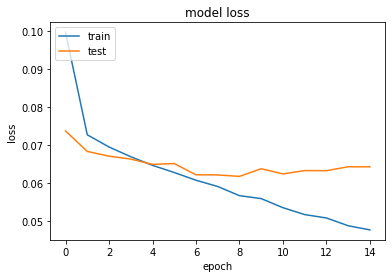

In [520]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [521]:
out = model.predict(x=graytrain[0:5000]).reshape(5000,32,32,24)

#Output array to store converted RGB values
finalOut = np.zeros(shape=(6000,32,32,3),dtype='int32') 

#find max
for i in range(0,5000):
    for j in range(0,32):
        for k in range(0,32):
            m = np.argmax(out[i,j,k])
            #Assign to nearest cluster
            finalOut[i,j,k] = clusters[m]

Image 1


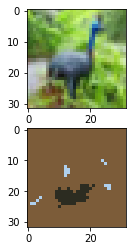

In [522]:
print("Image 1")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[0])
axarr[1].imshow(finalOut[0])

Image 2


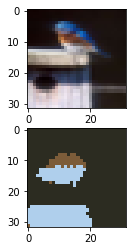

In [523]:
print("Image 2")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[1])
axarr[1].imshow(finalOut[1])

Image 3


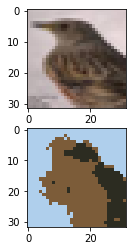

In [524]:
print("Image 3")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[2])
axarr[1].imshow(finalOut[2])

Image 4


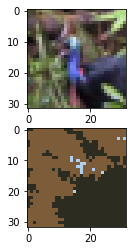

In [525]:
print("Image 4")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[3])
axarr[1].imshow(finalOut[3])

Image 5


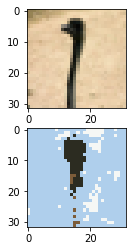

In [526]:
print("Image 5")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[4])
axarr[1].imshow(finalOut[4])

Image 6


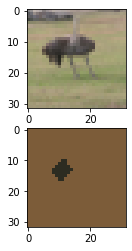

In [527]:
print("Image 6")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[5])
axarr[1].imshow(finalOut[5])

Image 7


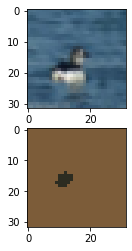

In [528]:
print("Image 7")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[6])
axarr[1].imshow(finalOut[6])

Image 8


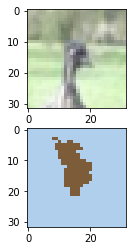

In [529]:
print("Image 8")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[7])
axarr[1].imshow(finalOut[7])

Image 9


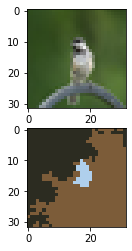

In [530]:
print("Image 9")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[8])
axarr[1].imshow(finalOut[8])

Image 10


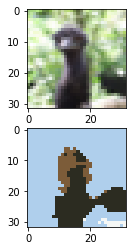

In [531]:
print("Image 10")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[9])
axarr[1].imshow(finalOut[9])

**1(g) Repeat whole exercise with k=32**

In [532]:
km = KMeans(n_clusters=32, random_state=0).fit(pixels)
#Centers of clusters (aka main colors)
[c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31,c32] = km.cluster_centers_

c1 = c1.astype('int32')
c2 = c2.astype('int32')
c3 = c3.astype('int32')
c4 = c4.astype('int32')
c5 = c4.astype('int32')
c6 = c4.astype('int32')
c7 = c4.astype('int32')
c8 = c4.astype('int32')
c9 = c4.astype('int32')
c10 = c4.astype('int32')
c11 = c4.astype('int32')
c12 = c4.astype('int32')
c13 = c4.astype('int32')
c14 = c4.astype('int32')
c15 = c4.astype('int32')
c16 = c4.astype('int32')
c17 = c4.astype('int32')
c18 = c4.astype('int32')
c19 = c4.astype('int32')
c20 = c4.astype('int32')
c21 = c4.astype('int32')
c22 = c4.astype('int32')
c23 = c4.astype('int32')
c24 = c4.astype('int32')
c25 = c4.astype('int32')
c26 = c4.astype('int32')
c27 = c4.astype('int32')
c28 = c4.astype('int32')
c29 = c4.astype('int32')
c30 = c4.astype('int32')
c31 = c4.astype('int32')
c32 = c4.astype('int32')

clusters = [c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31,c32]

In [533]:
#Assign to nearest class using one hot encoding
newX = np.zeros(shape=(6000,32,32,32),dtype='int32') #32 possible colors to encode

for i in range(0,6000):
    for j in range(0,32):
        for k in range(0,32):
            old = x[i,j,k]
            minC = 0
            minDist = 1000
            for c in range(0,32):
                dist = linalg.norm(old-clusters[c])
                if dist < minDist:
                    minDist = dist
                    minC = c
            #Assign to nearest cluster
            newX[i,j,k,minC] = 1

In [534]:
newX = newX.reshape(-1, 32*32*32)
newX = newX.astype('float32')
newXtrain = newX[0:5000]
newXtest = newX[5000:]

In [536]:
#Create a tf model
model = tfk.Sequential()

#Add 2 convolutional layers
model.add(tfk.layers.Conv2D(filters = 64, kernel_size=5, strides=1,activation='relu', input_shape=(32,32,1)))
model.add(tfk.layers.Conv2D(filters = 64, kernel_size=5, strides=2,activation='relu'))
    
#Flatten before passing through MLP
model.add(tfk.layers.Flatten())

#Add 2 MLP layers
model.add(tfk.layers.Dense(512, activation='relu'))

#Second layer must have 4069 neurons (output layer)
model.add(tfk.layers.Dense(32768, activation='linear'))

#define loss
#use a loss function that supports multilabel classification
def lossF(y_actual, y_pred):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(y_actual, y_pred)
    return tf.reduce_mean(loss)


optimizer = tfk.optimizers.Adam(1e-3)

#compile model
model.compile(loss=lossF, optimizer=optimizer)

#start training the model
history = model.fit(x=graytrain, y=newXtrain, validation_split = 0.1, epochs=15, batch_size=32)

Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 29s 6ms/sample - loss: 0.0822 - val_loss: 0.0577
Epoch 2/15
4500/4500 [==============================] - 27s 6ms/sample - loss: 0.0583 - val_loss: 0.0555
Epoch 3/15
4500/4500 [==============================] - 27s 6ms/sample - loss: 0.0554 - val_loss: 0.0548
Epoch 4/15
4500/4500 [==============================] - 27s 6ms/sample - loss: 0.0535 - val_loss: 0.0527
Epoch 5/15
4500/4500 [==============================] - 28s 6ms/sample - loss: 0.0518 - val_loss: 0.0511
Epoch 6/15
4500/4500 [==============================] - 28s 6ms/sample - loss: 0.0501 - val_loss: 0.0500
Epoch 7/15
4500/4500 [==============================] - 27s 6ms/sample - loss: 0.0487 - val_loss: 0.0498
Epoch 8/15
4500/4500 [==============================] - 26s 6ms/sample - loss: 0.0473 - val_loss: 0.0507
Epoch 9/15
4500/4500 [==============================] - 26s 6ms/sample - loss: 0.0465 - val_loss: 0.0490
Epoch 10

In [537]:
results = model.evaluate(graytest, newXtest, batch_size=128)
print('test loss:', results)

1000/1000 [==============================] - 1s 948us/sample - loss: 0.0541
test loss: 0.054105276554822924


dict_keys(['loss', 'val_loss'])


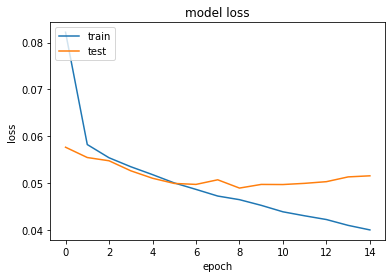

In [538]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [539]:
out = model.predict(x=graytrain[0:5000]).reshape(5000,32,32,32)

#Output array to store converted RGB values
finalOut = np.zeros(shape=(6000,32,32,3),dtype='int32') 

#find max
for i in range(0,5000):
    for j in range(0,32):
        for k in range(0,32):
            m = np.argmax(out[i,j,k])
            #Assign to nearest cluster
            finalOut[i,j,k] = clusters[m]

Image 1


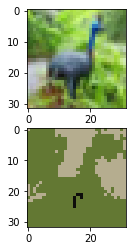

In [540]:
print("Image 1")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[0])
axarr[1].imshow(finalOut[0])

Image 2


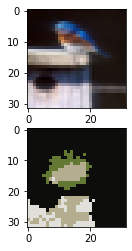

In [541]:
print("Image 2")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[1])
axarr[1].imshow(finalOut[1])

Image 3


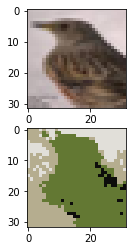

In [542]:
print("Image 3")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[2])
axarr[1].imshow(finalOut[2])

Image 4


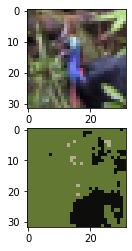

In [543]:
print("Image 4")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[3])
axarr[1].imshow(finalOut[3])

Image 5


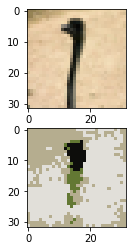

In [544]:
print("Image 5")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[4])
axarr[1].imshow(finalOut[4])

Image 6


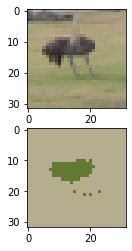

In [545]:
print("Image 6")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[5])
axarr[1].imshow(finalOut[5])

Image 7


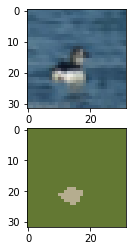

In [546]:
print("Image 7")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[6])
axarr[1].imshow(finalOut[6])

Image 8


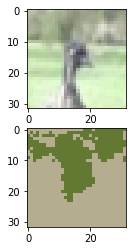

In [547]:
print("Image 8")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[7])
axarr[1].imshow(finalOut[7])

Image 9


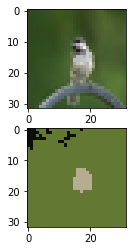

In [548]:
print("Image 9")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[8])
axarr[1].imshow(finalOut[8])

Image 10


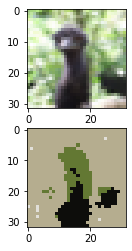

In [549]:
print("Image 10")
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(x[9])
axarr[1].imshow(finalOut[9])